# Import libraries

In [51]:
import pandas as pd
import numpy as np
from random import gauss
from pandas.plotting import autocorrelation_plot
import warnings
import itertools
from random import random

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt


import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
# import matplotlib as mpl
import seaborn as sns     

In [5]:
# set data folder and standard image size 20x10
class CFG:
    data_folder = 'data/'
    img_dim1 = 20
    img_dim2 = 10
    
    
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})

# Data


<AxesSubplot:xlabel='date'>

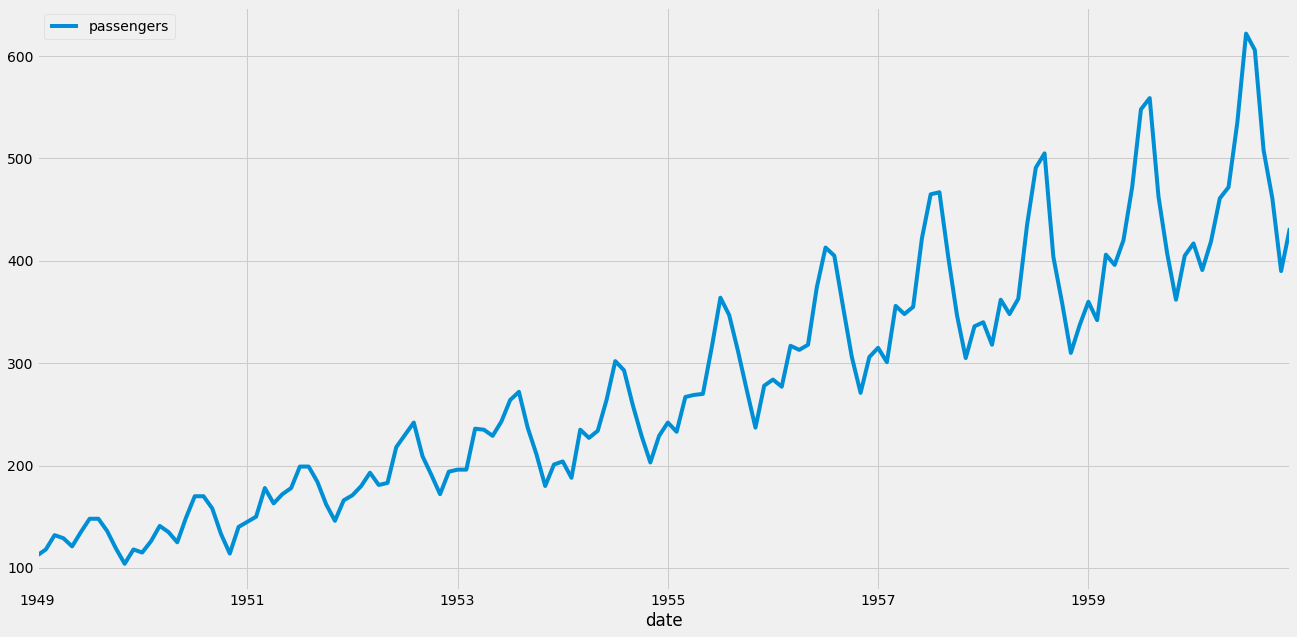

In [33]:
series = pd.read_csv(CFG.data_folder + 'passengers.csv')
series['date'] = pd.to_datetime(series['date'])
series.set_index('date').plot()

In [35]:
series.set_index('date')

,passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


# Seasonal decomposition

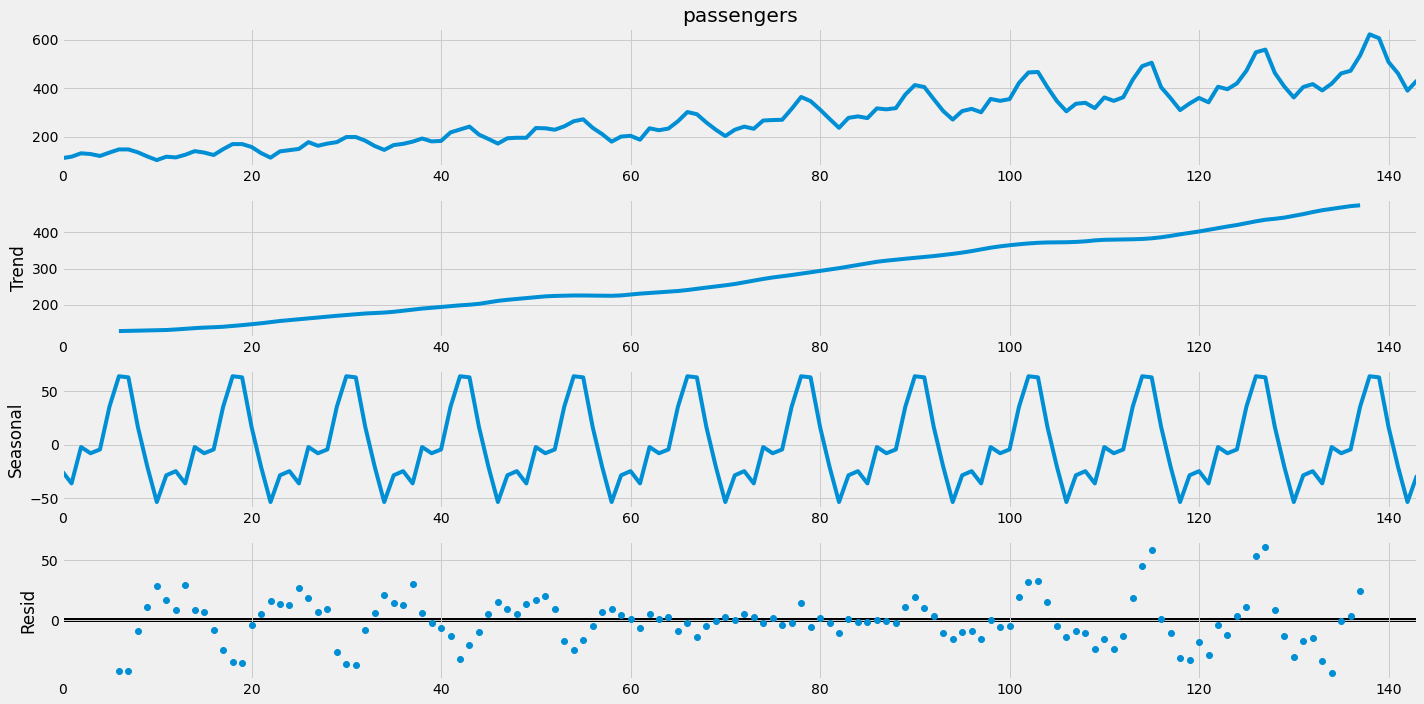

In [44]:
decomp = sm.tsa.seasonal_decompose(series['passengers'], model='additive', filt=None, period=12, two_sided=True, extrapolate_trend=0)
figure = decomp.plot()
plt.show()

There seems to be a pattern in the Residual part, so let's try the multiplicative model:

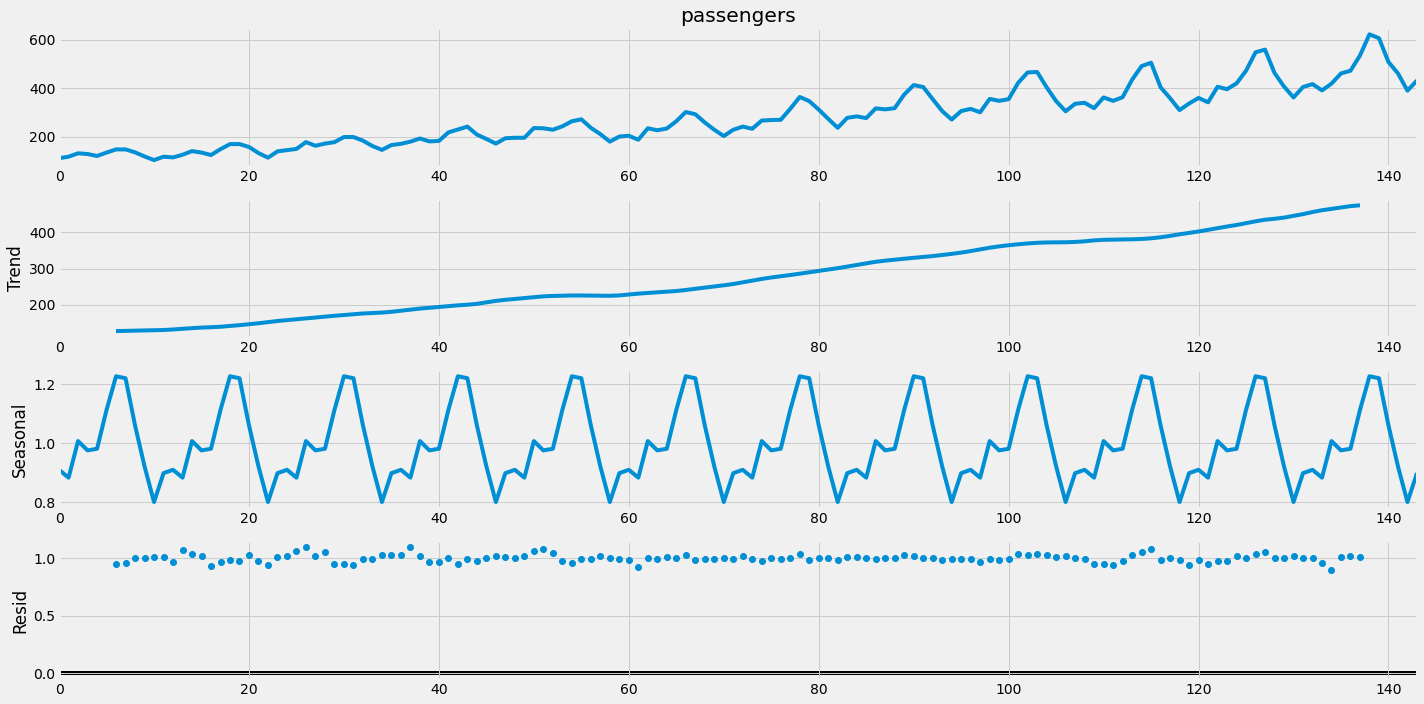

In [45]:
decomp = sm.tsa.seasonal_decompose(series['passengers'], model='multiplicative', filt=None, period=12, two_sided=True, extrapolate_trend=0)
figure = decomp.plot()
plt.show()

# Stationarity
To define things more formally, a stationary time series is one whose unconditional joint probability distribution does not change when shifted in time. This implies that parameters such as mean and variance also do not change over time.

Since stationarity is an assumption underlying many statistical procedures used in time series analysis, non-stationary data are often transformed to become stationary. A trend stationary process is not strictly stationary, but can easily be transformed into a stationary process by removing the underlying trend, which is solely a function of time; the same holds true for a stationary process with an added cyclical component.

The core idea is that it's much easier to model dynamic behavior over time if the statistical properties do not change: oscillations happen around the same level, the amplitude does not change too much etc (in other words, the probability distribution of $X_t$ is the same as the distribution of $X_t + h$) - such models are well understood. Algorithms are likely to yield better predictions if we apply them to stationary processes, because we do not need to worry about e.g. concept drift between our training and test sets.

Here I will show the following quick methods for making time series (more) stationary:

1. differencing the series
2. taking the log of the series
3. power transforms

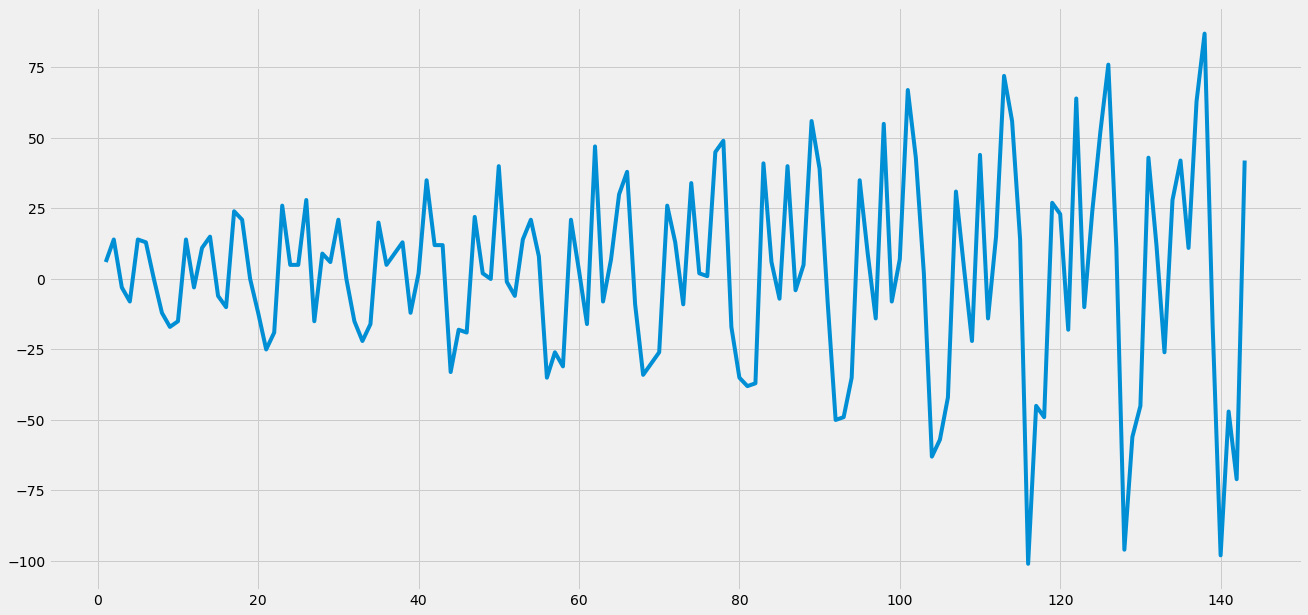

In [77]:
series['passengers3'] = series['passengers'].diff()
series.passengers3.plot()
plt.show()

In [82]:
result = adfuller(series.passengers3[10:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.830154
p-value: 0.054094


Oscillation happens around a fixed level, but the amplitude is increasing over time.

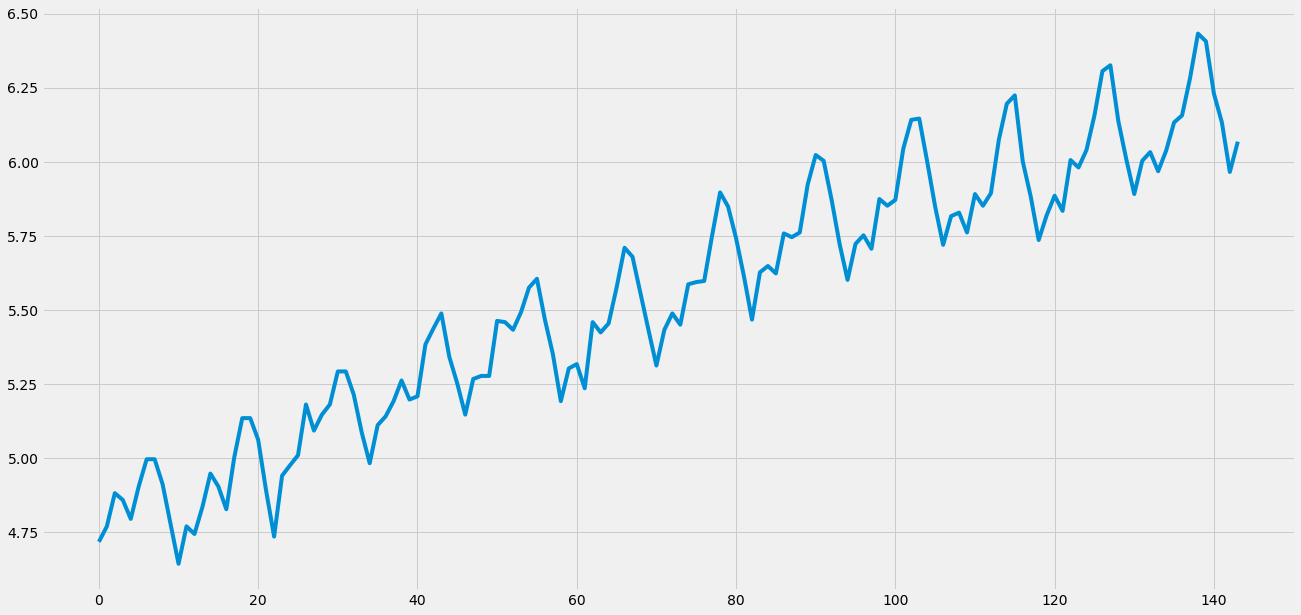

In [78]:
series['passengers2'] = np.log(series['passengers'])
series.passengers2.plot()
plt.show()

In [80]:
result = adfuller(series.passengers2[10:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.623643
p-value: 0.470820


The amplitude remains constant, but the upward trend remains.

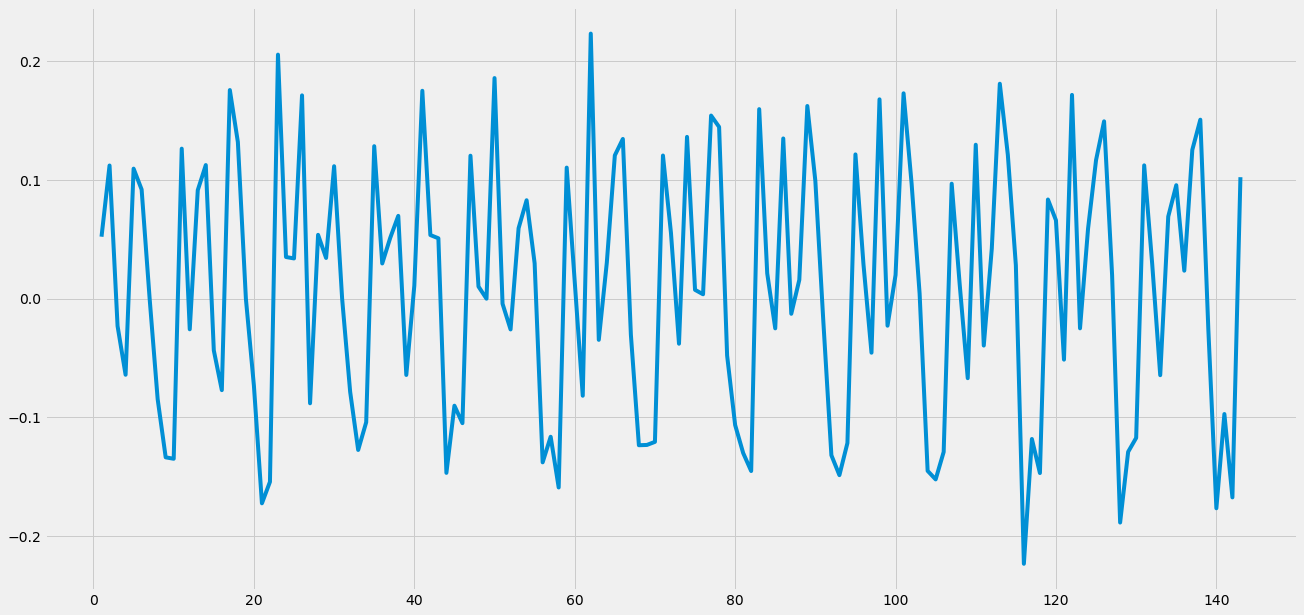

In [79]:
series['passengers4'] = series['passengers'].apply(np.log).diff()
series.passengers4.plot()
plt.show()

In [83]:
result = adfuller(series.passengers4[10:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Null hypothesis of non-stationarity rejected')

ADF Statistic: -3.086110
p-value: 0.027598
Null hypothesis of non-stationarity rejected


# Exponential Smoothing
Standard starting points for forecasting: regression and exponential smoothing.

Exponential smoothing takes into account the (exponentially) weighted average of the past and has low requirements and can therefore be very fastly implemented.

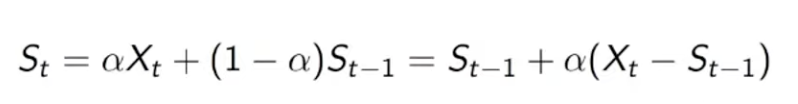

With a higher alpha you rely more on recent observations, while a lower alpha gives more weight to older data (leads to smoother predictions).

Here presented:
1. Single Exponential Smoothing (SES) - takes into account levels
2. Double Exponential Smoothing (Holt) - levels and trends
3. Triple Exponential Smoothing (Holt-Winters) - levels and trends and seasonality

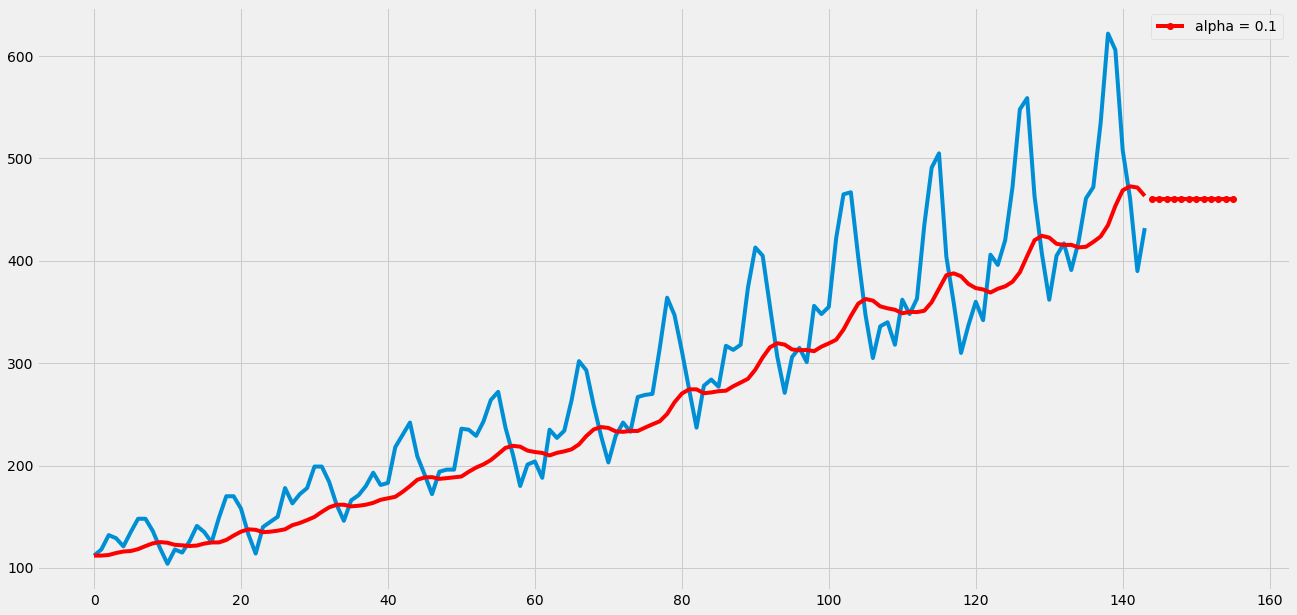

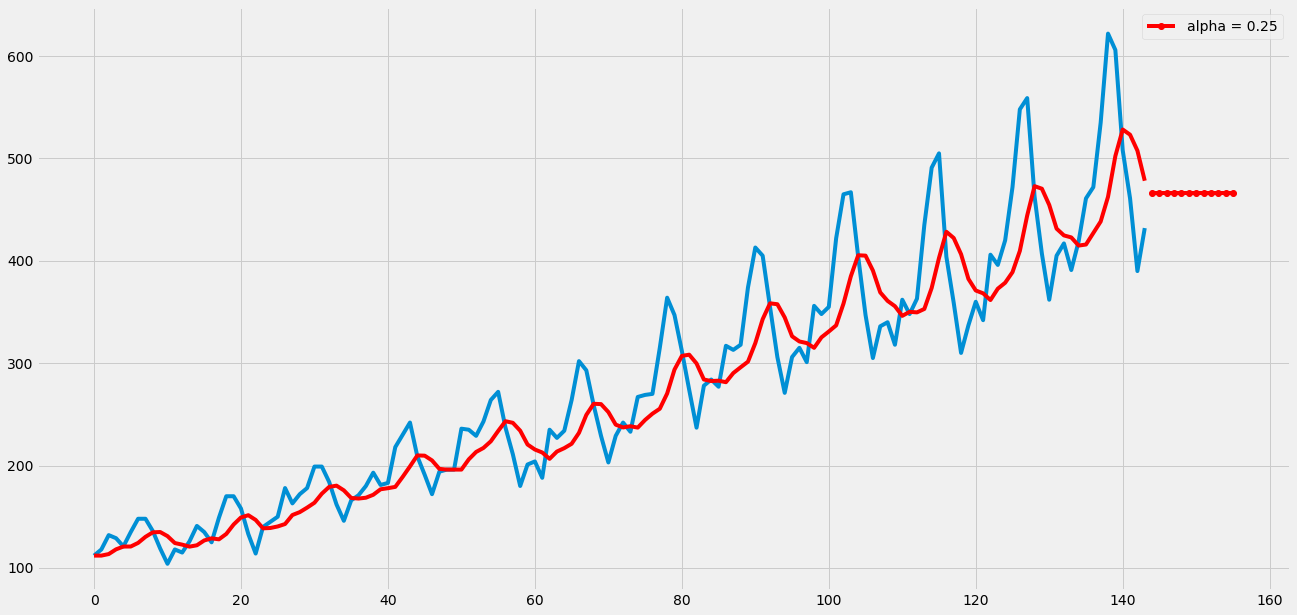

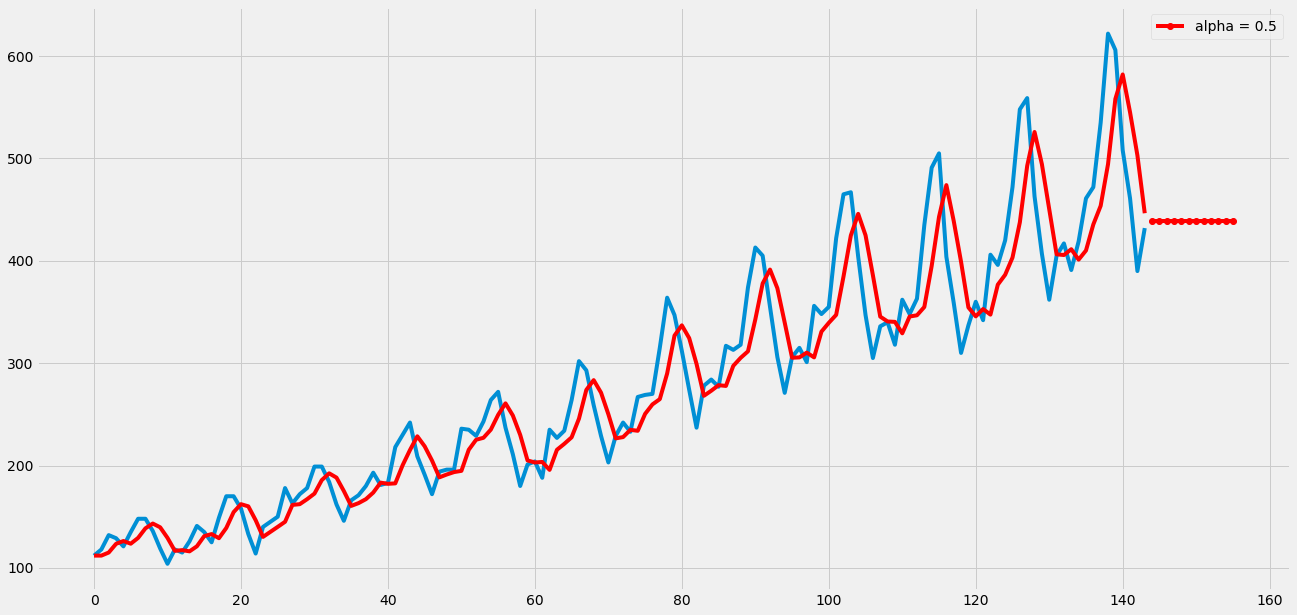

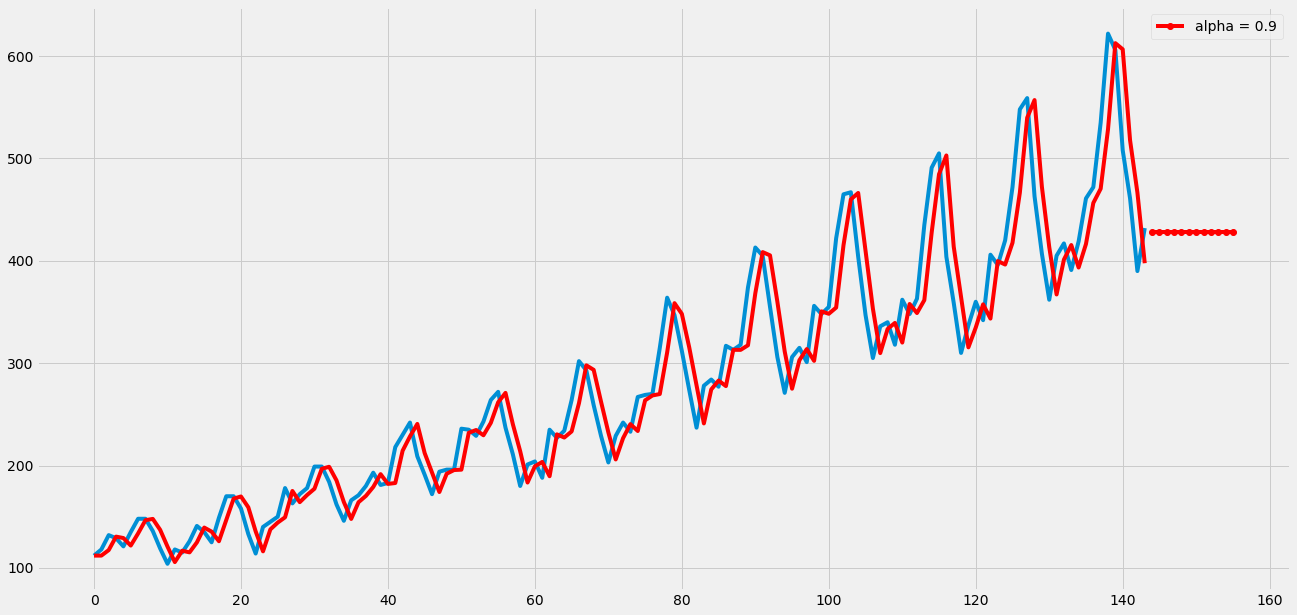

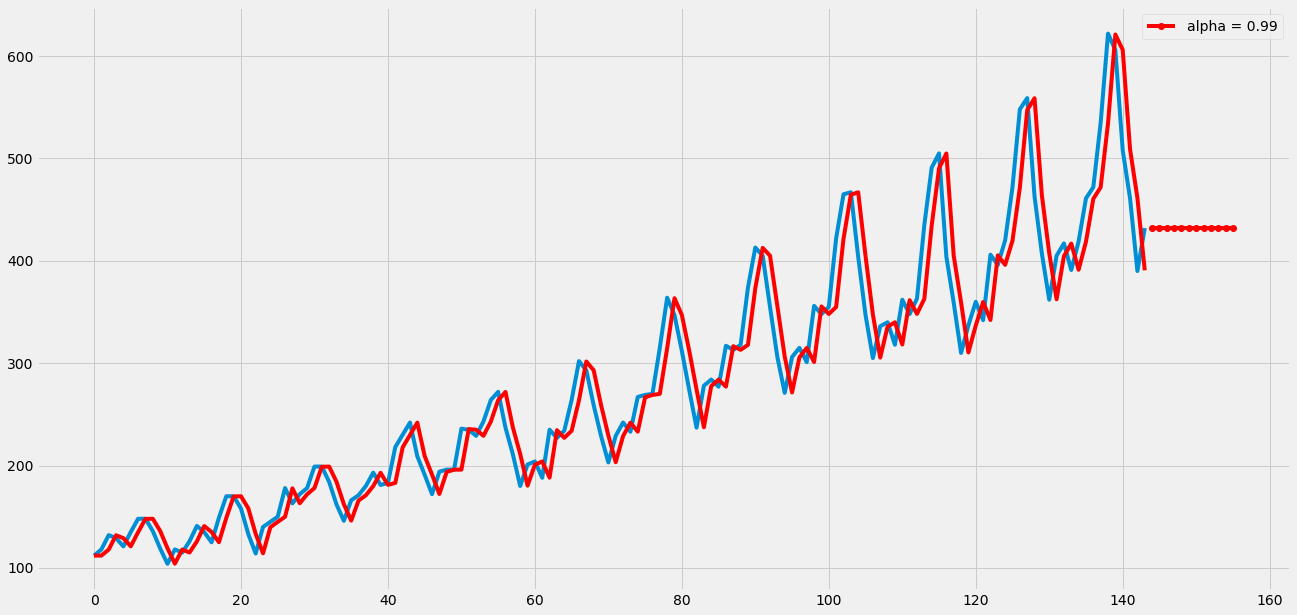

In [55]:
for alpha_sm in [0.1, 0.25 , 0.5, 0.9, 0.99]:
    df = series.copy()
    df['passengers'].plot.line()
    fit1 = SimpleExpSmoothing(df['passengers']).fit(smoothing_level = alpha_sm  ,optimized=False)
    fcast1 = fit1.forecast(12).rename('alpha = ' + str(alpha_sm))
    fcast1.plot(marker='o', color='red', legend=True)
    fit1.fittedvalues.plot(  color='red')
    plt.show()

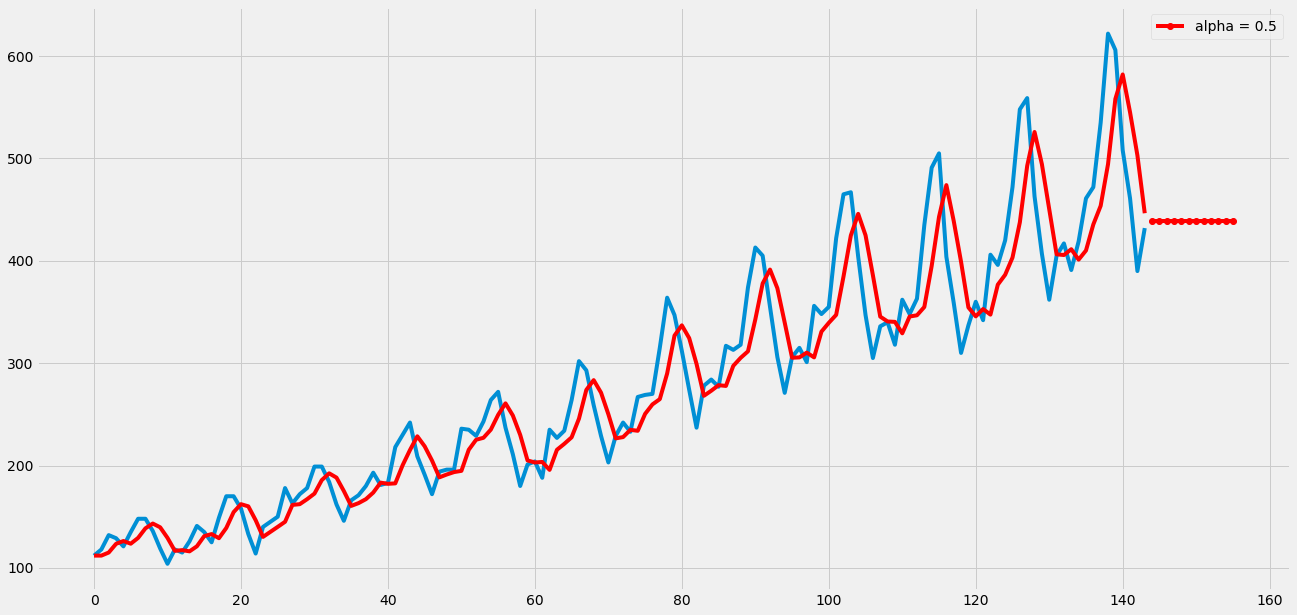

/var/folders/_m/cq3r85ys541d12f3j4rnvfs80000gn/T/ipykernel_27985/2962411687.py:14: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  fit1 = Holt(df['passengers']).fit(smoothing_level=0.5, smoothing_slope=0.5, optimized=False)


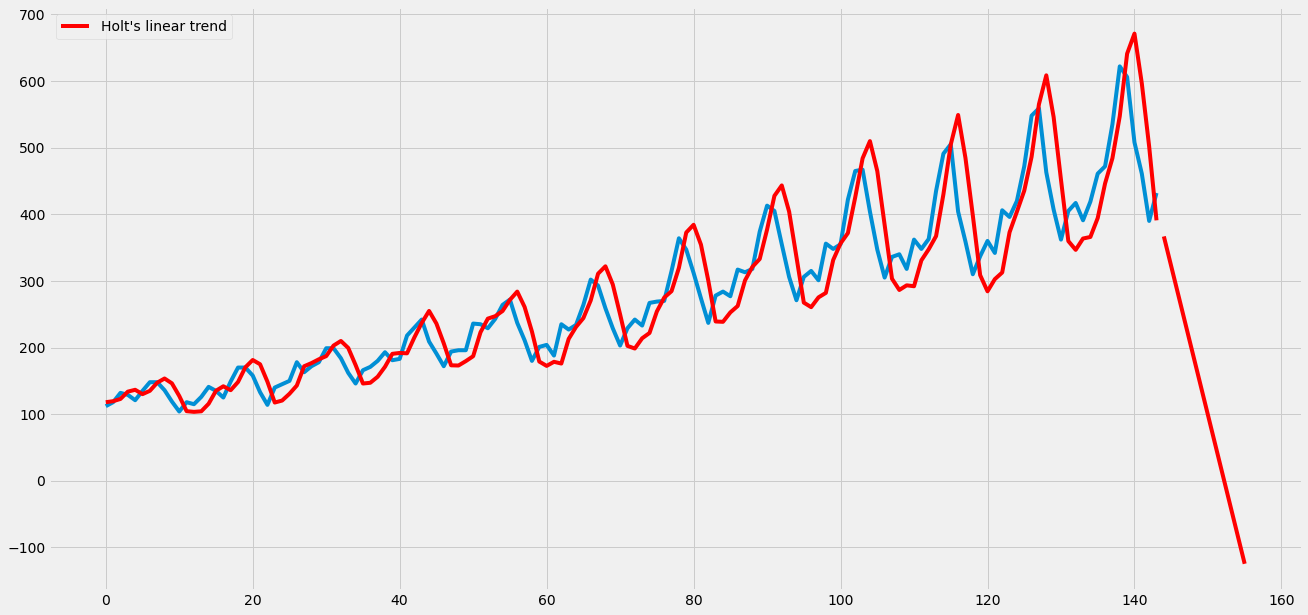

/var/folders/_m/cq3r85ys541d12f3j4rnvfs80000gn/T/ipykernel_27985/2962411687.py:22: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  fit1 = Holt(df['passengers']).fit(smoothing_level=0.05, smoothing_slope=0.5, optimized=False)


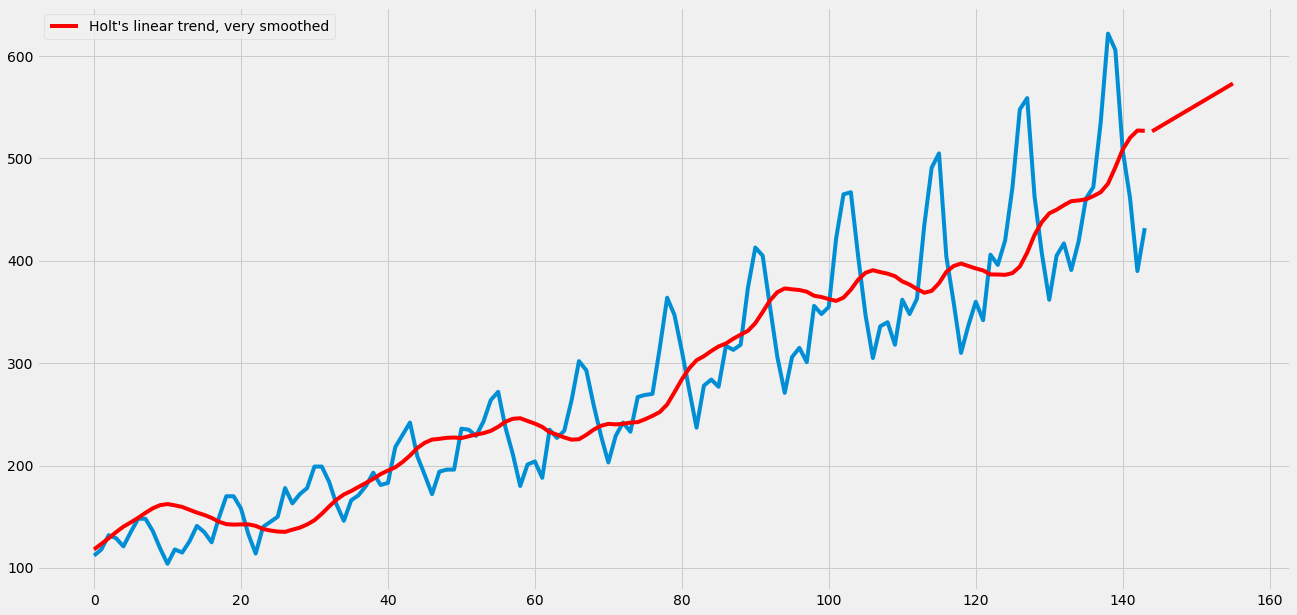

In [69]:
alpha_sm = 0.5

df = series.copy()
df['passengers'].plot.line()
fit1 = SimpleExpSmoothing(df['passengers']).fit(smoothing_level = alpha_sm  ,optimized=False)
fcast1 = fit1.forecast(12).rename('alpha = ' + str(alpha_sm))
fcast1.plot(marker='o', color='red', legend=True)
fit1.fittedvalues.plot(  color='red')
plt.show()


df = series.copy()
df['passengers'].plot.line()
fit1 = Holt(df['passengers']).fit(smoothing_level=0.5, smoothing_slope=0.5, optimized=False)
fcast1 = fit1.forecast(12).rename("Holt's linear trend")
fit1.fittedvalues.plot(color='red')
fcast1.plot(color='red', legend=True)
plt.show()

df = series.copy()
df['passengers'].plot.line()
fit1 = Holt(df['passengers']).fit(smoothing_level=0.05, smoothing_slope=0.5, optimized=False)
fcast1 = fit1.forecast(12).rename("Holt's linear trend, very smoothed")
fit1.fittedvalues.plot(color='red')
fcast1.plot(color='red', legend=True)
plt.show()

Not good: it is simply an extrapolation of the most recent (smoothed) trend in the data which means we can expect the forecast to repeat the last trend soon (in this case negative) or to be too smoothed with a very small alpha.

Solution: Complete prediction is composed of the sum of level and trend and the difference with simple exponential smoothing is that we need a second parameter to smooth the trend - as before, those can be set based on expert judgement or estimated (jointly) from the data.

The Holt-Winters method:

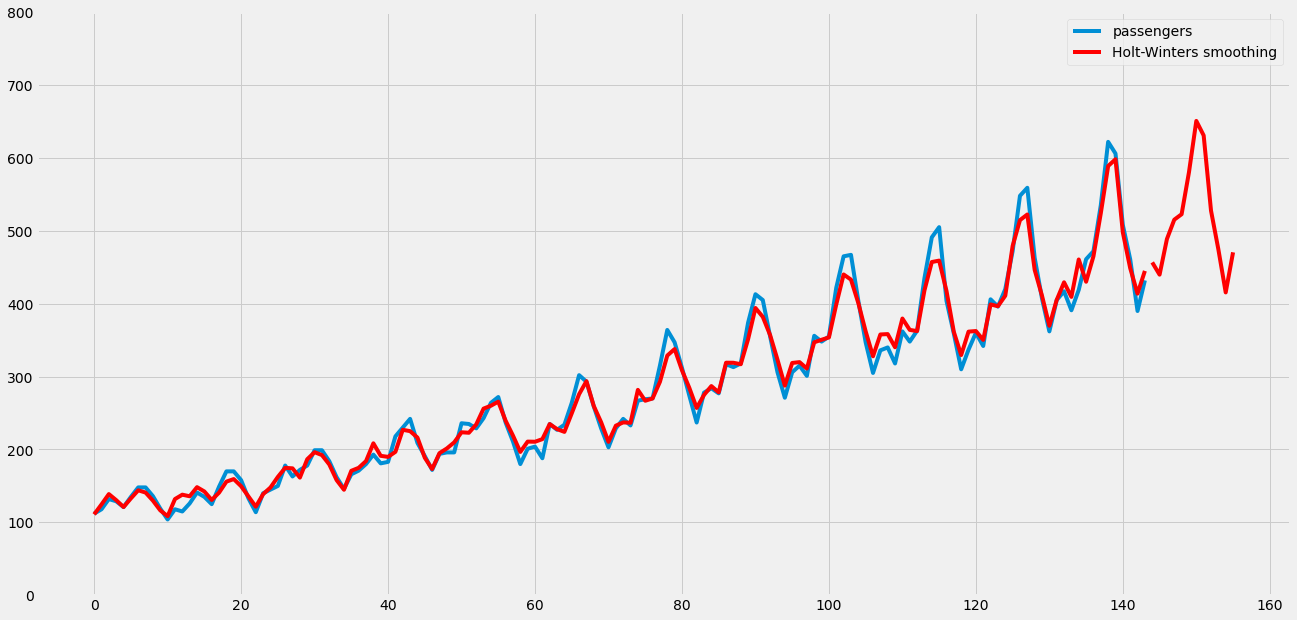

In [75]:
alpha = 0.5
df = pd.read_csv(CFG.data_folder + 'passengers.csv', usecols = ['passengers'])
df.plot.line()
fit1 = ExponentialSmoothing(df, seasonal_periods=12, trend='add', seasonal='add')
fit1 = fit1.fit(smoothing_level=0.5)#,use_boxcox=True)
fit1.fittedvalues.plot(color='red')
fit1.forecast(12).rename("Holt-Winters smoothing").plot(color='red', legend=True)

plt.ylim(0, 800); plt.show()